Calculating the streamfunction, sanity check!

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from collections import OrderedDict

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37225,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:36479,Total threads: 1
Dashboard: /proxy/33451/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:39261,


In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [4]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)

# cc.querying.get_variables(session, experiment='1deg_jra55_ryf_cont')

Calculate overturning streamfunction:

In [47]:
expt = '1deg_jra55_ryf_cont'
yr_beg = '2480-01-02'
yr_end = '2499-12-31'

psi = cc.querying.getvar(expt, 'ty_trans_rho', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')
psiGM = cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')

# convert from kg m**-1 to Sv
rho = 1035 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
psiGM = psiGM / (1e6*rho)

# Now, cumulatively sum the transport in the vertical. Note that in MOM5 the ty_trans_rho_GM variable is 
# computed differently and does not require summing in the vertical. Once the calculation has been laid out, 
# we then load the variable to force the computation to occur.
psi_avg = psi.cumsum('potrho') - psi.sum('potrho')
psi_cont = (psi_avg + psiGM).mean('time').load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

In [26]:
expt = '1deg_jra55_ryf_cool_x1'
yr_beg = '2480-01-02'
yr_end = '2499-12-31'

psi = cc.querying.getvar(expt, 'ty_trans_rho', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')
psiGM = cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')

# convert from kg m**-1 to Sv
rho = 1035 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
psiGM = psiGM / (1e6*rho)

# Now, cumulatively sum the transport in the vertical. Note that in MOM5 the ty_trans_rho_GM variable is 
# computed differently and does not require summing in the vertical. Once the calculation has been laid out, 
# we then load the variable to force the computation to occur.
psi_avg = psi.cumsum('potrho') - psi.sum('potrho')
psi_cool = (psi_avg + psiGM).mean('time').load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

In [27]:
expt = '1deg_jra55_ryf_warm_x1'
yr_beg = '2480-01-02'
yr_end = '2499-12-31'

psi = cc.querying.getvar(expt, 'ty_trans_rho', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')
psiGM = cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')

# convert from kg m**-1 to Sv
rho = 1035 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
psiGM = psiGM / (1e6*rho)

# Now, cumulatively sum the transport in the vertical. Note that in MOM5 the ty_trans_rho_GM variable is 
# computed differently and does not require summing in the vertical. Once the calculation has been laid out, 
# we then load the variable to force the computation to occur.
psi_avg = psi.cumsum('potrho') - psi.sum('potrho')
psi_warm = (psi_avg + psiGM).mean('time').load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

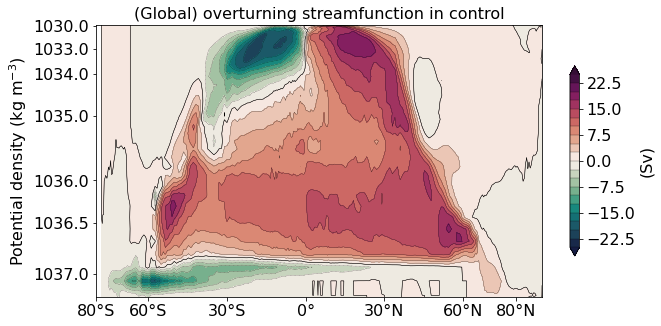

In [59]:
### Plotting ###

fig, ax1 = plt.subplots(1,1,figsize=(10, 5))
ticks = np.linspace(-25,25,21)
yticks = np.array([1030, 1033, 1034, 1035, 1036,1036.5, 1037])
plot_range = [-80, 80]

scfac = 4  ## A power to set the stretching
p1 = ax1.contourf(psi_cont.grid_yu_ocean, (psi_cont.potrho - 1028) ** scfac, psi_cont, cmap=cm.cm.curl, levels=ticks, extend='both')

# add colour bar
#cax = fig.add_axes([0.075, -.01, 0.25, 0.015]) # position: [x0, y0, width, height]
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
cb.set_label(label='(Sv)', size=16)
cb.ax.tick_params(labelsize=16)
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.locator = tick_locator
# cb.update_ticks()

p11a = ax1.contour(psi_cont.grid_yu_ocean, (psi_cont.potrho - 1028) ** scfac, psi_cont, levels=ticks, colors='k', linewidths=0.25)
p11 = ax1.contour(psi_cont.grid_yu_ocean, (psi_cont.potrho - 1028) ** scfac, psi_cont, levels=[0.0,], colors='k', linewidths=0.5)
cb.add_lines(p11a) # add contours to colour bar
#cb.add_lines(p11) 

ax1.set_yticks((yticks-1028)**scfac)
ax1.set_yticklabels(yticks)
ax1.set_ylim([0.5**scfac, 9.2**scfac])

# ticklabel  size
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16); ax1.yaxis.major.formatter._useMathText = True # use scientific notation
ax1.xaxis.offsetText.set_fontsize(16) # change font size of exponent

ax1.invert_yaxis()
ax1.set_ylabel('Potential density (kg m$^{-3}$)', fontsize=16);

ax1.set_xticks([-80,-60,-30,0,30,60,80])
ax1.set_xticklabels(['80°S','60°S','30°S','0°','30°N','60°N','80°N'], minor=False)

ax1.set_title('(Global) overturning streamfunction in control', fontsize=16)
                         
plt.savefig('rho_lat_streamfunction_control.jpg', 
            dpi=300, bbox_inches='tight')

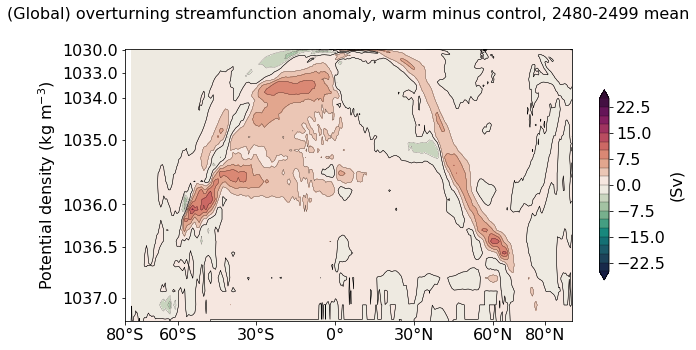

In [41]:
### Plotting ###

fig, ax1 = plt.subplots(1,1,figsize=(10, 5))
ticks = np.linspace(-25,25,21)
yticks = np.array([1030, 1033, 1034, 1035, 1036,1036.5, 1037])
plot_range = [-80, 80]

psi_anom = psi_warm - psi_cont

scfac = 4  ## A power to set the stretching
p1 = ax1.contourf(psi_anom.grid_yu_ocean, (psi_anom.potrho - 1028) ** scfac, psi_anom, cmap=cm.cm.curl, levels=ticks, extend='both')

# add colour bar
#cax = fig.add_axes([0.075, -.01, 0.25, 0.015]) # position: [x0, y0, width, height]
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
cb.set_label(label='(Sv)', size=16)
cb.ax.tick_params(labelsize=16)
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.locator = tick_locator
# cb.update_ticks()  

p11a = ax1.contour(psi_anom.grid_yu_ocean, (psi_anom.potrho - 1028) ** scfac, psi_anom, levels=ticks, colors='k', linewidths=0.25)
p11 = ax1.contour(psi_anom.grid_yu_ocean, (psi_anom.potrho - 1028) ** scfac, psi_anom, levels=[0.0,], colors='k', linewidths=0.5)
cb.add_lines(p11a) # add contours to colour bar
#cb.add_lines(p11) 

ax1.set_yticks((yticks-1028)**scfac)
ax1.set_yticklabels(yticks)
ax1.set_ylim([0.5**scfac, 9.2**scfac])

# ticklabel  size
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16); ax1.yaxis.major.formatter._useMathText = True # use scientific notation
ax1.xaxis.offsetText.set_fontsize(16) # change font size of exponent

ax1.invert_yaxis()
ax1.set_ylabel('Potential density (kg m$^{-3}$)', fontsize=16);

ax1.set_xticks([-80,-60,-30,0,30,60,80])
ax1.set_xticklabels(['80°S','60°S','30°S','0°','30°N','60°N','80°N'], minor=False)

ax1.set_title('(Global) overturning streamfunction anomaly, warm minus control, 2480-2499 mean', fontsize=16, pad=30)
                         
plt.savefig('rho_lat_streamfunction_warm_anom.jpg', 
            dpi=300, bbox_inches='tight')

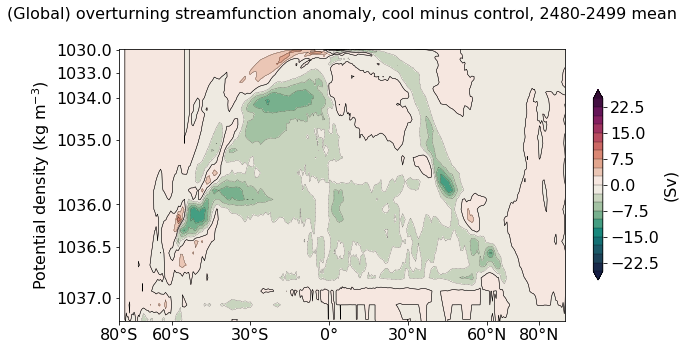

In [42]:
### Plotting ###

fig, ax1 = plt.subplots(1,1,figsize=(10, 5))
ticks = np.linspace(-25,25,21)
yticks = np.array([1030, 1033, 1034, 1035, 1036,1036.5, 1037])
plot_range = [-80, 80]

psi_anom = psi_cool - psi_cont

scfac = 4  ## A power to set the stretching
p1 = ax1.contourf(psi_anom.grid_yu_ocean, (psi_anom.potrho - 1028) ** scfac, psi_anom, cmap=cm.cm.curl, levels=ticks, extend='both')

# add colour bar
#cax = fig.add_axes([0.075, -.01, 0.25, 0.015]) # position: [x0, y0, width, height]
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
cb.set_label(label='(Sv)', size=16)
cb.ax.tick_params(labelsize=16)
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.locator = tick_locator
# cb.update_ticks()  

p11a = ax1.contour(psi_anom.grid_yu_ocean, (psi_anom.potrho - 1028) ** scfac, psi_anom, levels=ticks, colors='k', linewidths=0.25)
p11 = ax1.contour(psi_anom.grid_yu_ocean, (psi_anom.potrho - 1028) ** scfac, psi_anom, levels=[0.0,], colors='k', linewidths=0.5)
cb.add_lines(p11a) # add contours to colour bar
#cb.add_lines(p11) 

ax1.set_yticks((yticks-1028)**scfac)
ax1.set_yticklabels(yticks)
ax1.set_ylim([0.5**scfac, 9.2**scfac])

# ticklabel  size
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16); ax1.yaxis.major.formatter._useMathText = True # use scientific notation
ax1.xaxis.offsetText.set_fontsize(16) # change font size of exponent

ax1.invert_yaxis()
ax1.set_ylabel('Potential density (kg m$^{-3}$)', fontsize=16);

ax1.set_xticks([-80,-60,-30,0,30,60,80])
ax1.set_xticklabels(['80°S','60°S','30°S','0°','30°N','60°N','80°N'], minor=False)

ax1.set_title('(Global) overturning streamfunction anomaly, cool minus control, 2480-2499 mean', fontsize=16, pad=30)
                         
plt.savefig('rho_lat_streamfunction_cool_anom.jpg', 
            dpi=300, bbox_inches='tight')

Calculate GMOC strength using the method from above

In [43]:
expt = '1deg_jra55_ryf_cont'
yr_beg = '2400-01-02'
yr_end = '2499-12-31'

psi = cc.querying.getvar(expt, 'ty_trans_rho', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')
psiGM = cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')

# convert from kg m**-1 to Sv
rho = 1035 # mean density of sea-water in kg/m^3
psi = psi / (1e6 * rho) # converts kg/s to Sv
psiGM = psiGM / (1e6 * rho)

# Now, cumulatively sum the transport in the vertical. Note that in MOM5 the ty_trans_rho_GM variable is 
# computed differently and does not require summing in the vertical. Once the calculation has been laid out, 
# we then load the variable to force the computation to occur.
psi_avg = psi.cumsum('potrho') - psi.sum('potrho')
psi_avg = (psi_avg + psiGM)

GMOC_control = psi_avg.sel(method = 'Nearest', grid_yu_ocean = 26).sel(potrho = slice(1035.5, None)).max('potrho').groupby('time.year').mean('time').load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

In [44]:
expt = '1deg_jra55_ryf_cool_x1'
yr_beg = '2400-01-02'
yr_end = '2499-12-31'

psi = cc.querying.getvar(expt, 'ty_trans_rho', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')
psiGM = cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')

# convert from kg m**-1 to Sv
rho = 1035 # mean density of sea-water in kg/m^3
psi = psi / (1e6 * rho) # converts kg/s to Sv
psiGM = psiGM / (1e6 * rho)

# Now, cumulatively sum the transport in the vertical. Note that in MOM5 the ty_trans_rho_GM variable is 
# computed differently and does not require summing in the vertical. Once the calculation has been laid out, 
# we then load the variable to force the computation to occur.
psi_avg = psi.cumsum('potrho') - psi.sum('potrho')
psi_avg = (psi_avg + psiGM)

GMOC_cool = psi_avg.sel(method = 'Nearest', grid_yu_ocean = 26).sel(potrho = slice(1035.5, None)).max('potrho').groupby('time.year').mean('time').load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

In [45]:
expt = '1deg_jra55_ryf_warm_x1'
yr_beg = '2400-01-02'
yr_end = '2499-12-31'

psi = cc.querying.getvar(expt, 'ty_trans_rho', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')
psiGM = cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')

# convert from kg m**-1 to Sv
rho = 1035 # mean density of sea-water in kg/m^3
psi = psi / (1e6 * rho) # converts kg/s to Sv
psiGM = psiGM / (1e6 * rho)

# Now, cumulatively sum the transport in the vertical. Note that in MOM5 the ty_trans_rho_GM variable is 
# computed differently and does not require summing in the vertical. Once the calculation has been laid out, 
# we then load the variable to force the computation to occur.
psi_avg = psi.cumsum('potrho') - psi.sum('potrho')
psi_avg = (psi_avg + psiGM)

GMOC_warm = psi_avg.sel(method = 'Nearest', grid_yu_ocean = 26).sel(potrho = slice(1035.5, None)).max('potrho').groupby('time.year').mean('time').load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

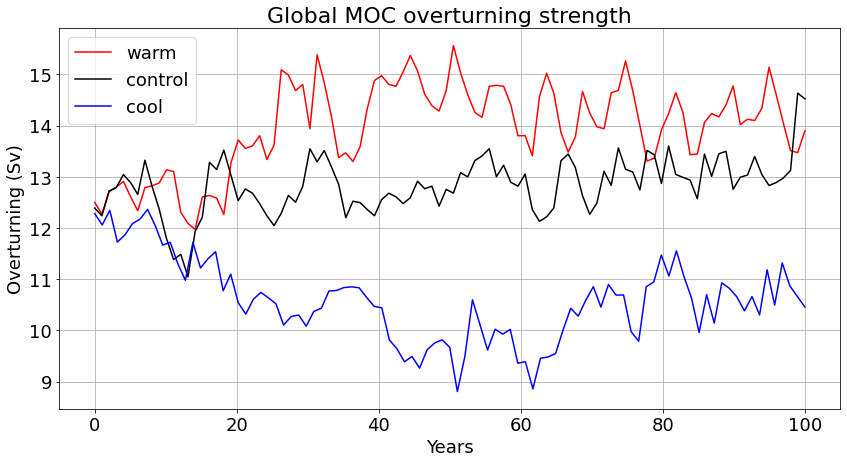

In [46]:
plt.figure(figsize=(14, 7))

plt.plot(np.linspace(0,100,GMOC_warm.year.shape[0]), GMOC_warm, label = 'warm', color = 'r')
plt.plot(np.linspace(0,100,GMOC_control.year.shape[0]), GMOC_control, label = 'control', color = 'k')
plt.plot(np.linspace(0,100,GMOC_cool.year.shape[0]), GMOC_cool, label = 'cool', color = 'b')

fontsize = 18
xlims = plt.xlim()
plt.xlabel('Years', fontsize=fontsize)
plt.ylabel('Overturning (Sv)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title('Global MOC overturning strength', fontsize=fontsize+4)
plt.grid()
plt.savefig('GMOC_strength.pdf', bbox_inches='tight', dpi=300)

In [60]:
expt = '1deg_jra55_ryf_cont'
yr_beg = '2400-01-02'
yr_end = '2401-12-31'

psi_test = cc.querying.getvar(expt, 'ty_trans', session, start_time = yr_beg, end_time = yr_end).sum('grid_xt_ocean')

VariableNotFoundError: No files were found containing 'ty_trans' in the '1deg_jra55_ryf_cont' experiment

In [61]:
psi_test

NameError: name 'psi_test' is not defined